## 3D Autoencoder

In [5]:
import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np

Only openning one file.

In [6]:
z = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1979/01/ERA5.pl.temperature.nc')#, combine='by_coords')

In [3]:
z.t

<xarray.DataArray 't' (time: 744, level: 37, latitude: 721, longitude: 1440)>
dask.array<open_dataset-ab7925c67aa204edf417ac084993b356t, shape=(744, 37, 721, 1440), dtype=float32, chunksize=(744, 37, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.75 -179.5 ... 179.25 179.5 179.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 1979-01-01 ... 1979-01-31T23:00:00
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

Just want to see how the data looks

In [4]:
t = getattr(z, 't')

In [5]:
data = t[dict(level=36, longitude=slice(None, 40), latitude =slice(None, 40) )].values

In [6]:
data.shape

(744, 40, 40)

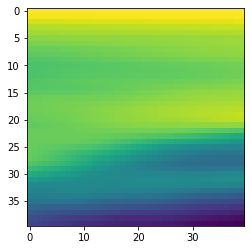

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(data[568], interpolation='nearest')
plt.show()

## DataLoader

I still don't know how to chunk the data. TODO: Chunking.

In [1]:
from tensorflow import keras
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            try:
                data.append(ds[var].sel(level=levels))
            except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        self.data = xr.concat(data, 'level').transpose('time', 'latitude', 'longitude', 'level')
        self.mean = self.data.mean(('time', 'latitude', 'longitude')).compute() if mean is None else mean
        self.std = self.data.std('time').mean(('latitude', 'longitude')).compute() if std is None else std
        
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

## Model

Based on the paper "Deep learning for in situ data compression of large turbulent flow simulations".

In [2]:
%load_ext tensorboard
import tensorflow as tf
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv3D, ReLU, LeakyReLU, BatchNormalization,\
                                    Add, Flatten, Dense, Conv3DTranspose
from tensorflow.keras.models import Model


def residual_block(x: Tensor, filters: int, kernel_size = (3, 3, 3)) -> Tensor:
    y = Conv3D(kernel_size=kernel_size, strides= 1, filters=filters, padding="same")(x)
    y = ReLU()(x)
    y = Conv3D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)
    return y

def encoder(x: Tensor):
    kernel_size = (3, 3, 3)
    C = 4
    num_res_blocks = 12
    num_comp_lay = 3
    
    x = Conv3D(kernel_size=kernel_size, strides=1, filters=C, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    first_skip_conn = x
    
    for j in range(num_res_blocks):
        skip_connection = x
        x = residual_block(x, filters=C)
        x = Add()([skip_connection, x])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C, padding="same")(x)
    x = Add()([first_skip_conn, x])
    
    C_mult = [2, 2, 1]
    
    for i in range(num_comp_lay):
        C = int(x.get_shape()[-1])
        x = Conv3D(kernel_size=kernel_size, strides= 2, filters=C, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C_mult[i]*C, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)

        
    C = int(x.get_shape()[-1])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=int(C/2), padding="same")(x)

    return x

def decoder(x: Tensor):
    kernel_size = (3, 3, 3)
    num_res_blocks = 12
    nump_comp_lay = 3
    C = int(x.get_shape()[-1])
    
    x = Conv3D(kernel_size=kernel_size, strides=1, filters=2*C,padding="same")(x)
    
    C_div = [1, 2, 2]
    
    for i in range(3):
        C = int(x.get_shape()[-1])
        C_over_div = int(int(C)/C_div[i])
        x = Conv3D(kernel_size=kernel_size,strides= 1,filters=C_over_div, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv3DTranspose(C_over_div, kernel_size=kernel_size, strides=2, padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)

    skip_connection = x
    
    C = 4

    for i in range(num_res_blocks):
        B_skip_connection = x
        x = residual_block(x, filters=C)
        x = Add()([B_skip_connection, x])
        
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters=C, padding="same")(x)
    x = Add()([skip_connection, x])
    
    x = Conv3D(kernel_size=kernel_size, strides= 1, filters= 1, padding="same")(x)

    return x

def Autoencoder():
    
    inputs = Input(shape=(32, 40, 40, 1))
    t = BatchNormalization()(inputs)
    enc = encoder(t)
    dec = decoder(enc)
    
    model = Model(inputs, dec)

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
    )

    return model

In [3]:
model = Autoencoder() 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 40, 40,  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 40, 40, 1 4           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 40, 40, 4 112         batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 40, 40, 4 0           conv3d[0][0]                     
_______________________________________________________________________________________

## Loading the data

In [ ]:
from collections import OrderedDict

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.

#Define train and test datasets.
dg_train = DataGenerator(z.sel(time=slice('1979')), dic, batch_size=bs, load=True, shuffle=True) # Using generator
#dg_test=....

# Jupyter kernel restarts #

## Training model

In [ ]:
# Using tensorboard.
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#history = model.fit(dg_train, validation_data=dg_test, epochs=100, callbacks=[tensorboard_callback])